In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from tensorflow.keras import layers, models 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
#for dirname, _, filenames in os.walk('../input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load model

In [3]:
model = keras.models.load_model("./detectionModel.keras")

In [4]:
def wb(channel, perc=0.05):
    mi, ma = (np.percentile(channel, perc), np.percentile(channel, 100.0-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel

def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    # Apply white balance to each channel separately
    # The error was likely occurring because we were trying to apply wb to all channels at once
    b, g, r = cv2.split(image)
    b_wb = wb(b, 0.05)
    g_wb = wb(g, 0.05)
    r_wb = wb(r, 0.05)
    
    # Merge the white-balanced channels
    imWB = cv2.merge([b_wb, g_wb, r_wb])
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
    img_clahe = clahe.apply(gray_image)
    
    # Convert back to RGB
    img = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)
    
    # Resize to 224x224 pixels
    processed_image = cv2.resize(img, (224, 224))
    
    return processed_image

In [5]:
# For a single test image
test_image_path = "./image.jpeg"
processed_image = preprocess_image(test_image_path)
processed_image = np.array(processed_image) / 255.0

test_image_path2 = "./image2.jpeg"
processed_image2 = preprocess_image(test_image_path2)
processed_image2 = np.array(processed_image2) / 255.0

## LIME

In [6]:
import tensorflow as tf
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

c:\Users\kusha\anaconda3\envs\venvP3_10\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


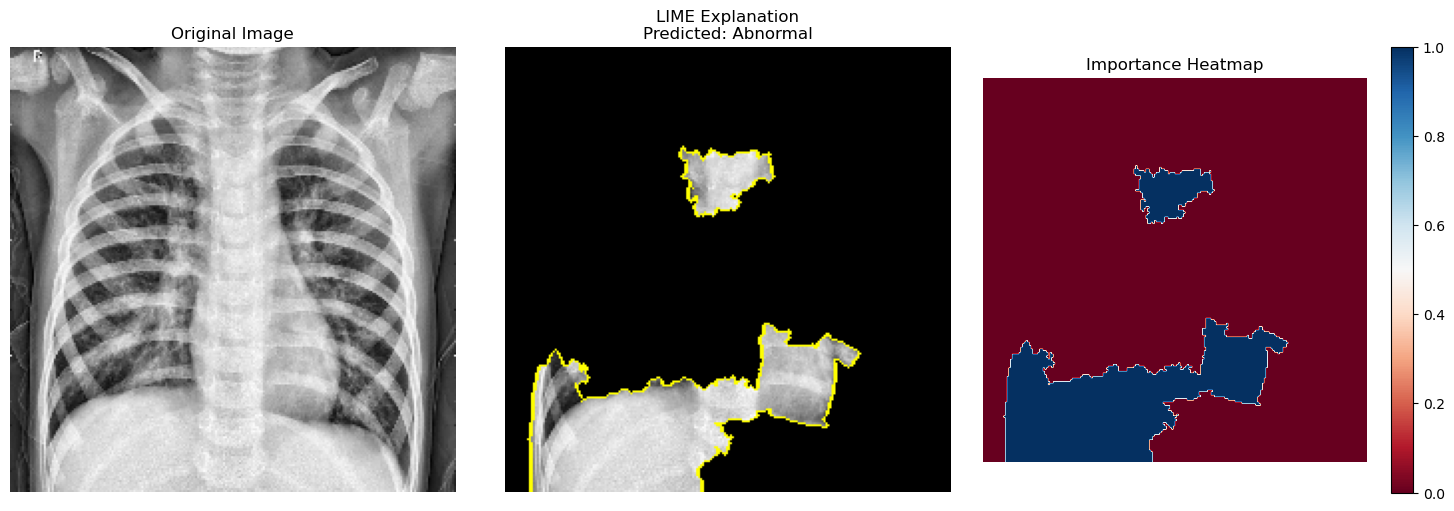


Top features that influenced the prediction:
Feature 11: Impact score = -0.0335
Feature 8: Impact score = -0.0218
Feature 19: Impact score = -0.0186
Feature 17: Impact score = -0.0182
Feature 45: Impact score = 0.0175


In [7]:
def predict_wrapper(images):
    """Wrapper for model prediction to work with LIME"""
    # Ensure images are in the right format
    images = tf.cast(images, tf.float32)
    predictions = model.predict(images)
    return predictions

def explain_prediction(image, model, class_names=['Normal', 'Abnormal']):
    """
    Generate LIME explanation for a single image
    
    Args:
        image: Single image (224, 224, 3)
        model: Trained model
        class_names: List of class names
    """
    # Create the LIME explainer
    explainer = lime_image.LimeImageExplainer()
    
    # Convert image to array if it's not
    image_array = np.array(image)
    
    # Generate explanation
    explanation = explainer.explain_instance(
        image_array, 
        predict_wrapper,
        top_labels=len(class_names),
        hide_color=0,
        num_samples=1000
    )
    
    # Get the most probable class
    top_label = explanation.top_labels[0]
    
    # Generate the explanation map
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=5,
        hide_rest=True
    )
    
    # Visualize the explanation
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(131)
    plt.imshow(image_array)
    plt.title('Original Image')
    plt.axis('off')
    
    # LIME explanation
    plt.subplot(132)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f'LIME Explanation\nPredicted: {class_names[top_label]}')
    plt.axis('off')
    
    # Heatmap only
    plt.subplot(133)
    plt.imshow(mask, cmap='RdBu')
    plt.title('Importance Heatmap')
    plt.colorbar()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print feature importance scores
    print("\nTop features that influenced the prediction:")
    ind = explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    for feature, importance in sorted(dict_heatmap.items(), key=lambda x: abs(x[1]), reverse=True)[:5]:
        print(f"Feature {feature}: Impact score = {importance:.4f}")
explain_prediction(
    processed_image,
    model,
    class_names=['Normal', 'Abnormal']
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


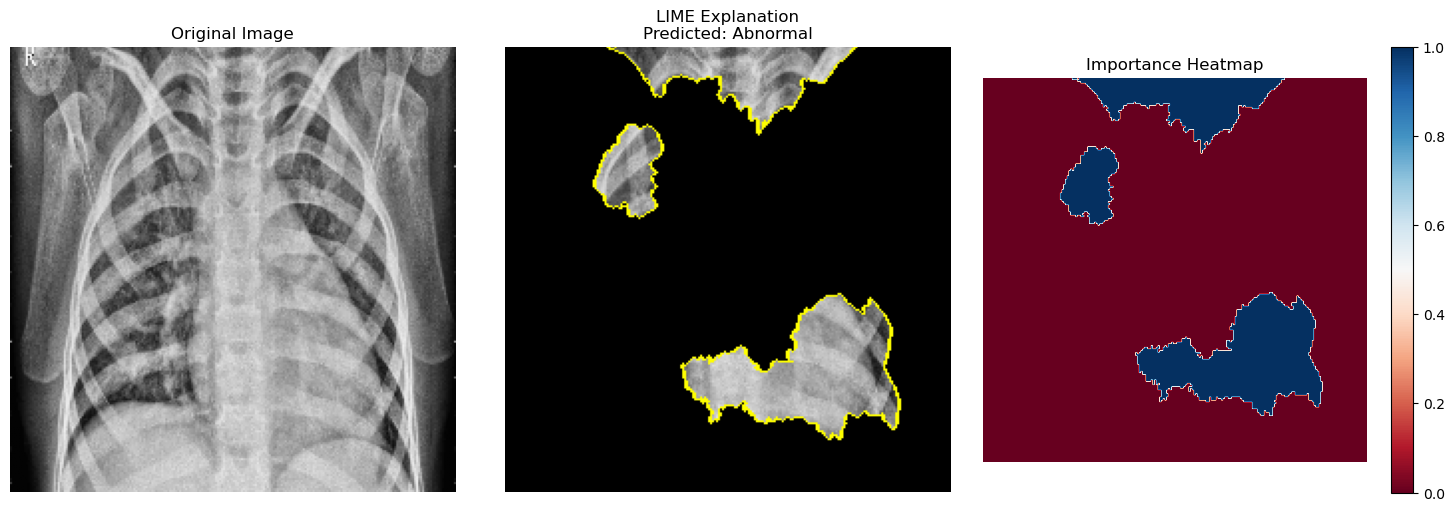


Top features that influenced the prediction:
Feature 18: Impact score = -0.0701
Feature 20: Impact score = -0.0380
Feature 25: Impact score = 0.0374
Feature 0: Impact score = 0.0374
Feature 17: Impact score = -0.0360


In [8]:
explain_prediction(
    processed_image2,
    model,
    class_names=['Normal', 'Abnormal']
)

In [9]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(processed_image, model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


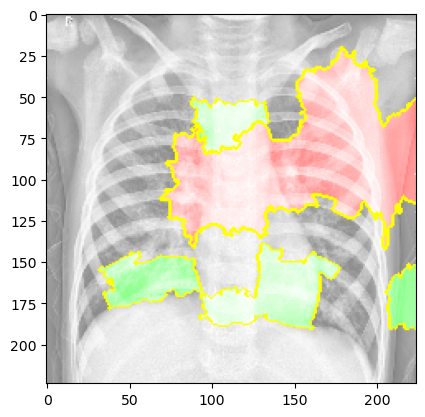

In [10]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

## GradCam

C:\Users\kusha\AppData\Local\Temp\ipykernel_13060\2194008692.py:17: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=100)])


Steps: 100	Scores: [50757.73828125],	Regularization: [('TotalVariation2D', [20.961708068847656]), ('Norm', [29.46162223815918])]
Steps: 200	Scores: [35302.6640625],	Regularization: [('TotalVariation2D', [15.01609992980957]), ('Norm', [28.78592872619629])]


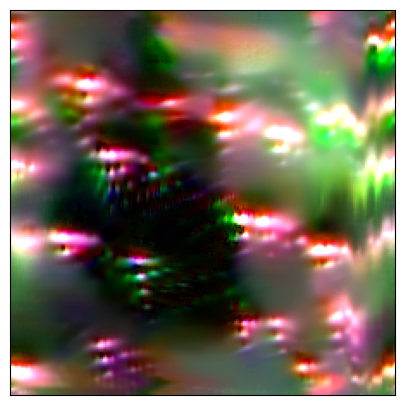

In [12]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.callbacks import Print

# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

# Create Activation Maximization object
activation_maximization = ActivationMaximization(model, model_modifier)

# Define loss function. 20 is the imagenet index corresponding to ouzel.
loss = lambda x: K.mean(x[:, 1])

# Generate max activation with debug printing
activation = activation_maximization(loss, callbacks=[Print(interval=100)])
image = activation[0].numpy().astype(np.uint8)

f, ax = plt.subplots(figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)
plt.show()

In [13]:
def loss(output):
    return (output[1][1], output[0][1])

# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

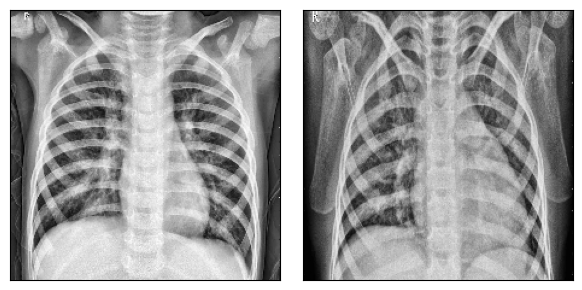

In [14]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


# Load images
img1 = processed_image
img2 = processed_image2

images = np.asarray([np.array(img1), np.array(img2)])



# Render
subprot_args = {
    'nrows': 1,
    'ncols': 2,
    'figsize': (6, 3),
    'subplot_kw': {'xticks': [], 'yticks': []}
}
f, ax = plt.subplots(**subprot_args)
for i in range(len(images)):
    ax[i].imshow(images[i])
plt.tight_layout()
plt.show()

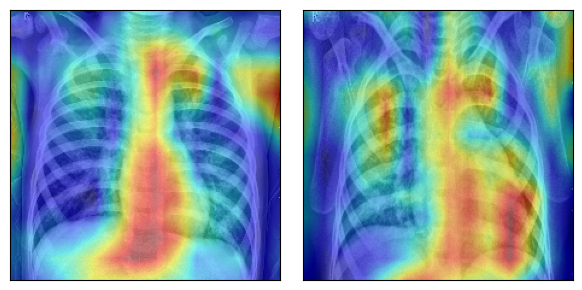

In [15]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize

# Create Gradcam object
gradcam = Gradcam(model, model_modifier, clone=False)

# Generate heatmap with GradCAM
cam = gradcam(loss, images)
cam = normalize(cam)

f, ax = plt.subplots(**subprot_args)
for i in range(len(cam)):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()